<a href="https://colab.research.google.com/github/fhdbbk/fastai-1/blob/main/08_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
# fastbook.setup_book()

     |████████████████████████████████| 720 kB 4.9 MB/s 
     |████████████████████████████████| 189 kB 41.3 MB/s 
     |████████████████████████████████| 48 kB 4.5 MB/s 
     |████████████████████████████████| 1.2 MB 37.6 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 51 kB 257 kB/s 
     |████████████████████████████████| 558 kB 60.3 MB/s 
     |████████████████████████████████| 130 kB 52.8 MB/s 


In [2]:
#hide
from fastbook import *
# import torch

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cpu'

# Collaborative Filtering Deep Dive

## A First Look at the Data

In [5]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [ ]:
doc(path.ls)

,Type,Default
n_max,NoneType,None
file_type,NoneType,None
file_exts,NoneType,None


In [4]:
path

Path('/root/.fastai/data/ml-100k')

In [5]:
!ls $path

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [8]:
!cat $path/README 

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

In [9]:
!cat $path/u.info

943 users
1682 items
100000 ratings


In [20]:
!head $path/u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


In [11]:
!head $path/u.user

1|24|M|technician|85711
2|53|F|other|94043
3|23|M|writer|32067
4|24|M|technician|43537
5|33|F|other|15213
6|42|M|executive|98101
7|57|M|administrator|91344
8|36|M|administrator|05201
9|29|M|student|01002
10|53|M|lawyer|90703


In [26]:
!head $path/u.item

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0
6|Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|01-Jan-1995||http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0
7|Twelve Monkeys (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|1|0|0|0
8|Babe (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Babe%20(1995)|0|0|0|0|1

In [12]:
!head $path/u.occupation

administrator
artist
doctor
educator
engineer
entertainment
executive
healthcare
homemaker
lawyer


In [13]:
path.ls()

(#23) [Path('/root/.fastai/data/ml-100k/u1.base'),Path('/root/.fastai/data/ml-100k/u4.test'),Path('/root/.fastai/data/ml-100k/ub.test'),Path('/root/.fastai/data/ml-100k/u3.test'),Path('/root/.fastai/data/ml-100k/u.genre'),Path('/root/.fastai/data/ml-100k/ub.base'),Path('/root/.fastai/data/ml-100k/u.data'),Path('/root/.fastai/data/ml-100k/u.info'),Path('/root/.fastai/data/ml-100k/u4.base'),Path('/root/.fastai/data/ml-100k/u2.base')...]

In [6]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
last_skywalker = np.array([0.98,0.9,-0.9])

In [8]:
user1 = np.array([0.9,0.8,-0.6])

In [9]:
(user1*last_skywalker).sum()

2.1420000000000003

In [10]:
casablanca = np.array([-0.99,-0.3,0.8])

In [11]:
(user1*casablanca).sum()

-1.611

## Learning the Latent Factors

## Creating the DataLoaders

In [12]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
# movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
#                      usecols=(0,1, 2, 3), names=('movie','title', 'date', 'url'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [13]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [14]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [15]:
dls.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

In [16]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [17]:
print(f'Shape of user_factors: {user_factors.shape}')
print(f'Shape of movie_factors: {movie_factors.shape}')

Shape of user_factors: torch.Size([944, 5])
Shape of movie_factors: torch.Size([1665, 5])


In [18]:
one_hot_3 = one_hot(3, n_users).float()
print(one_hot_3.shape)

torch.Size([944])


In [19]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [20]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

## Collaborative Filtering from Scratch

In [21]:
class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

In [22]:
ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you.'

In [24]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [25]:
te = Embedding(10, 3)
te(torch.tensor([1, 2, 3, 9]))

tensor([[ 0.0135, -0.0104, -0.0173],
        [-0.0068,  0.0059,  0.0042],
        [ 0.0002, -0.0028, -0.0073],
        [ 0.0060,  0.0108, -0.0016]], grad_fn=<EmbeddingBackward0>)

In [23]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

dls.show_batch() gives user_id, title, rating. While dls.one_batch() gives x, y where x gives user_id, movie_id and y gives rating. Why?

In [24]:
x[:10,:]

tensor([[ 661,  659],
        [ 861,  730],
        [ 766,    8],
        [  13, 1153],
        [ 429, 1185],
        [ 488, 1242],
        [ 675, 1638],
        [ 271,  987],
        [ 677,  772],
        [ 301, 1139]])

In [25]:
print(y.shape)
y[:10]

torch.Size([64, 1])


tensor([[4],
        [4],
        [4],
        [1],
        [3],
        [3],
        [3],
        [3],
        [1],
        [4]], dtype=torch.int8)

In [ ]:
doc(MSELossFlat)

,Type,Default
args,,
axis,int,-1
floatify,bool,True
reduction,str,mean


In [29]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [30]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.349329,1.280347,00:16
1,1.076102,1.094417,00:08
2,0.928614,0.974602,00:06
3,0.779988,0.884961,00:06
4,0.734354,0.873242,00:06


In [31]:
res = model(x[:10, :].to(device=device))
print(res.shape)
print(res)
print(y[:10, 0])

torch.Size([10])
tensor([3.6945, 4.5275, 3.7621, 2.2998, 2.7305, 3.4470, 3.7601, 2.8469, 3.1151, 3.6467], device='cuda:0', grad_fn=<SumBackward1>)
tensor([4, 4, 4, 1, 3, 3, 3, 3, 1, 4], dtype=torch.int8)


In [32]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [33]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.977199,0.995251,00:06
1,0.868061,0.914109,00:06
2,0.680133,0.871867,00:07
3,0.480875,0.875177,00:06
4,0.376345,0.878901,00:06


In [36]:
print(model(x[:10, :].to(device=device)))
print(y[:10, 0])

tensor([3.8994, 4.4892, 4.0877, 1.4156, 2.8974, 3.8005, 3.2691, 3.2636, 1.4047, 3.5399], device='cuda:0', grad_fn=<AddBackward0>)
tensor([4, 4, 4, 1, 3, 3, 3, 3, 1, 4], dtype=torch.int8)


In [35]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [35]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.929354,0.942862,00:10
1,0.844862,0.865170,00:10
2,0.599058,0.862759,00:21
3,0.421760,0.883946,00:16
4,0.285483,0.891066,00:10


In [36]:
print(model(x[:10, :].to(device=device))[:,0])
print(y[:10, 0])

tensor([3.6439, 4.0653, 3.6801, 1.7521, 2.9686, 3.5636, 3.1838, 3.1575, 1.3805, 3.4930], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([4, 4, 4, 1, 3, 3, 3, 3, 1, 4], dtype=torch.int8)


### Weight Decay

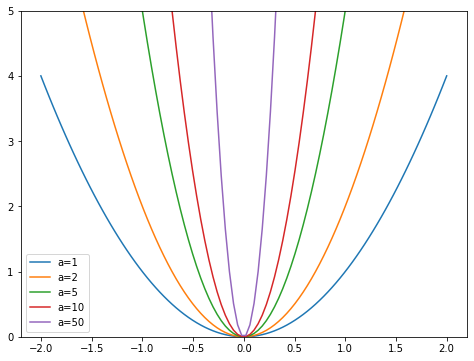

In [ ]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

In [37]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.937791,0.950311,00:11
1,0.881776,0.876389,00:12
2,0.717920,0.834832,00:11
3,0.605017,0.821339,00:07
4,0.475594,0.822432,00:07


In [38]:
print(model(x[:10, :].to(device=device))[:, 0])
print(y[:10, 0])

tensor([3.7057, 3.9659, 3.7627, 2.0458, 2.7254, 3.5489, 3.3794, 2.8902, 2.3442, 3.5742], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([4, 4, 4, 1, 3, 3, 3, 3, 1, 4], dtype=torch.int8)


### Creating Our Own Embedding Module

In [26]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [27]:
class T(Module):
    def __init__(self): 
      self.a = nn.Parameter(torch.ones(3))
      self.b = nn.Parameter(torch.zeros(4))

L(T().parameters())

(#2) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True),Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)]

In [28]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.5001],
        [ 0.1648],
        [-0.5951]], requires_grad=True)]

In [29]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [30]:
torch.zeros(3).normal_(0, 0.01)

tensor([ 0.0034,  0.0070, -0.0045])

In [31]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [32]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [33]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.952782,0.943390,00:10
1,0.868401,0.879164,00:10
2,0.731228,0.837519,00:10
3,0.572002,0.821874,00:10
4,0.469570,0.824006,00:10


In [34]:
print(model(x[:10, :].to(device=device)))
print(y[:10, 0])

tensor([3.7489, 4.2535, 3.7688, 2.2150, 2.7920, 3.7073, 3.2715, 3.0929, 2.1374, 3.5909], grad_fn=<AddBackward0>)
tensor([4, 4, 4, 1, 3, 3, 3, 3, 1, 4], dtype=torch.int8)


## Interpreting Embeddings and Biases

In [35]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Children of the Corn: The Gathering (1996)',
 'Robocop 3 (1993)',
 'Kansas City (1996)',
 'Amityville 3-D (1983)']

In [36]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 'Titanic (1997)',
 'Silence of the Lambs, The (1991)',
 "Schindler's List (1993)"]

In [55]:
print(ratings.groupby('title')['rating'].count())

title
'Til There Was You (1997)                  9
1-900 (1994)                               5
101 Dalmatians (1996)                    109
12 Angry Men (1957)                      125
187 (1997)                                41
                                        ... 
Young Guns II (1990)                      44
Young Poisoner's Handbook, The (1995)     41
Zeus and Roxanne (1997)                    6
unknown                                    9
Á köldum klaka (Cold Fever) (1994)         1
Name: rating, Length: 1664, dtype: int64


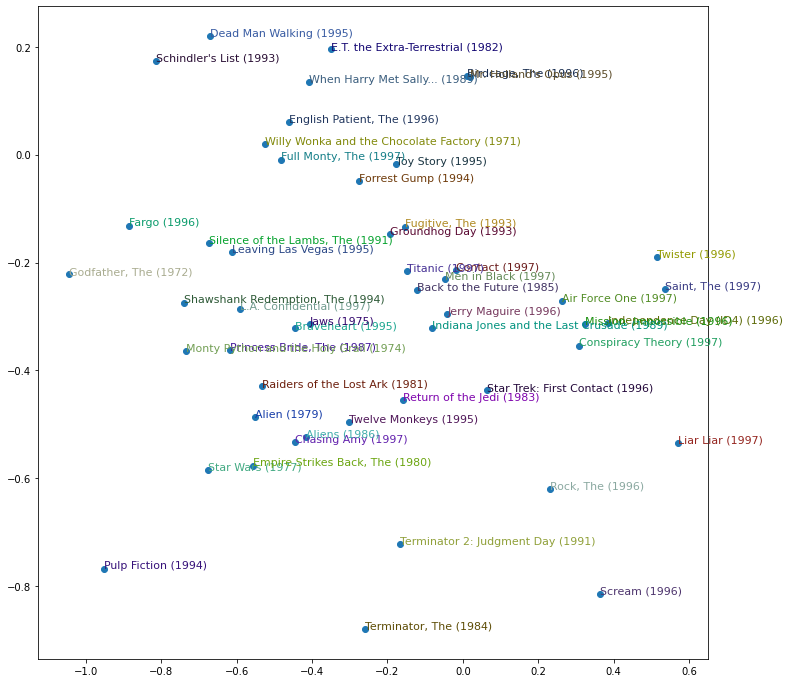

In [37]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Using fastai.collab

In [38]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [39]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.949689,0.963879,00:11
1,0.859769,0.884169,00:10
2,0.726825,0.834926,00:10
3,0.593114,0.821983,00:10
4,0.504934,0.822551,00:10


In [40]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [41]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Silence of the Lambs, The (1991)',
 'Titanic (1997)',
 'Rear Window (1954)',
 'Shawshank Redemption, The (1994)']

### Embedding Distance

In [42]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
print(idx)

1330


In [47]:
movie_factors[idx].shape

torch.Size([50])

In [48]:
movie_factors[idx][None].shape

torch.Size([1, 50])

In [49]:
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Farewell to Arms, A (1932)'

## Bootstrapping a Collaborative Filtering Model

## Deep Learning for Collaborative Filtering

In [50]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [51]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [52]:
model = CollabNN(*embs)

In [53]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.951949,0.964819,00:13
1,0.918020,0.918955,00:23
2,0.842033,0.878746,00:14
3,0.813052,0.862858,00:13
4,0.743418,0.866886,00:13


In [54]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.962718,0.991417,00:14
1,0.955918,0.921793,00:15
2,0.909540,0.887402,00:15
3,0.815553,0.864434,00:14
4,0.788305,0.867852,00:14


In [55]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=176, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=5.5)
  )
)

In [56]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

### Sidebar: kwargs and Delegates

### End sidebar

## Conclusion

## Questionnaire

1. What problem does collaborative filtering solve?
1. How does it solve it?
1. Why might a collaborative filtering predictive model fail to be a very useful recommendation system?
1. What does a crosstab representation of collaborative filtering data look like?
1. Write the code to create a crosstab representation of the MovieLens data (you might need to do some web searching!).
1. What is a latent factor? Why is it "latent"?
1. What is a dot product? Calculate a dot product manually using pure Python with lists.
1. What does `pandas.DataFrame.merge` do?
1. What is an embedding matrix?
1. What is the relationship between an embedding and a matrix of one-hot-encoded vectors?
1. Why do we need `Embedding` if we could use one-hot-encoded vectors for the same thing?
1. What does an embedding contain before we start training (assuming we're not using a pretained model)?
1. Create a class (without peeking, if possible!) and use it.
1. What does `x[:,0]` return?
1. Rewrite the `DotProduct` class (without peeking, if possible!) and train a model with it.
1. What is a good loss function to use for MovieLens? Why? 
1. What would happen if we used cross-entropy loss with MovieLens? How would we need to change the model?
1. What is the use of bias in a dot product model?
1. What is another name for weight decay?
1. Write the equation for weight decay (without peeking!).
1. Write the equation for the gradient of weight decay. Why does it help reduce weights?
1. Why does reducing weights lead to better generalization?
1. What does `argsort` do in PyTorch?
1. Does sorting the movie biases give the same result as averaging overall movie ratings by movie? Why/why not?
1. How do you print the names and details of the layers in a model?
1. What is the "bootstrapping problem" in collaborative filtering?
1. How could you deal with the bootstrapping problem for new users? For new movies?
1. How can feedback loops impact collaborative filtering systems?
1. When using a neural network in collaborative filtering, why can we have different numbers of factors for movies and users?
1. Why is there an `nn.Sequential` in the `CollabNN` model?
1. What kind of model should we use if we want to add metadata about users and items, or information such as date and time, to a collaborative filtering model?

### Further Research

1. Take a look at all the differences between the `Embedding` version of `DotProductBias` and the `create_params` version, and try to understand why each of those changes is required. If you're not sure, try reverting each change to see what happens. (NB: even the type of brackets used in `forward` has changed!)
1. Find three other areas where collaborative filtering is being used, and find out what the pros and cons of this approach are in those areas.
1. Complete this notebook using the full MovieLens dataset, and compare your results to online benchmarks. See if you can improve your accuracy. Look on the book's website and the fast.ai forum for ideas. Note that there are more columns in the full dataset—see if you can use those too (the next chapter might give you ideas).
1. Create a model for MovieLens that works with cross-entropy loss, and compare it to the model in this chapter.